<h1 style="font-family:candara; font-size:250%; background-color:#DBA506; color:#000000;">
    <center>IMDb database</center>
</h1>
<p style="color:#DBA506; font-family:candara; font-size:100%; text-align:center;"> 
    Exploratory data analysis
</p>


***

This database can be downloaded [here](https://www.imdb.com/interfaces/)

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
//This is used to make the table of contents!! 
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#---------change working directory to database location
import os 
print(os.getcwd())
os.chdir('C:\\Users\\cuspi\\Documents\\Databases\\IMDb') #Change working directory
print(os.getcwd()) #check it has changed

C:\Users\cuspi\Documents\GitHub\Projects
C:\Users\cuspi\Documents\Databases\IMDb


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Import data
names = pd.read_csv("data.tsv", sep='\t')
titles = pd.read_csv("data_1.tsv", sep='\t')
directors = pd.read_csv("data_2.tsv", sep='\t')
ratings = pd.read_csv("data_3.tsv", sep='\t')

C:\Users\cuspi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We now shortly explain the dataframes imported.

The **names** dataframe has the following columns:
- **nid** (string) - alphanumeric unique identifier of the name/person
- **name** (string)– name by which the person is most often credited
- **birth** – in YYYY format
- **death** – in YYYY format if applicable, else '\N'
- **primaryProfession** (array of strings)– the top-3 professions of the person
- **known_for_tid** (array of tconsts) – titles the person is known for


The **titles** dataframe has:
- **tid** (string) - alphanumeric unique identifier of the title
- **type** (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- **title** (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- **original_title** (string) - original title, in the original language
- **isAdult** (boolean) - 0: non-adult title; 1: adult title
- **year** (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- **end_series** (YYYY) – TV Series end year. ‘\N’ for all other title types
- **duration** – primary runtime of the title, in minutes
- **genres** (string array) – includes up to three genres associated with the title

The **directors** dataframe is made by
- **tid** (string) - alphanumeric unique identifier of the title
- **directors** (array of nconsts) - director(s) of the given title
- **writers** (array of nconsts) – writer(s) of the given title

The **ratings** table is composed by
- **tid** (string) - alphanumeric unique identifier of the title
- **rating** – weighted average of all the individual user ratings
- **votes** - number of votes the title has received




In [4]:
titles.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

In [5]:
# Rename columns
names.columns = ['nid', 'name', 'birth', 'death', 'primaryProfession', 'known_for_tid']
if len(titles.columns)>8:
    titles.columns = ['tid','type','title','original_title', 'isAdult','year','end_series','duration','genres']
    # #Get rid of end year of series
    titles = titles.drop(columns=['original_title','end_series'])
directors = directors.rename(columns ={'tconst':'tid'} )
ratings.columns = ['tid','rating', 'votes']

In [6]:
# Dataframe transformations
import re

names = names[names.birth != '\\N'] #There is a lot of people without a birthdate and this fact seems to also point at their relevance... (too harsh maybe?)  
names.death = pd.to_numeric(names.death, downcast='unsigned',errors='coerce')

# #There are some errors in isAdult column, where the year was the input. Got removed
titles = titles[titles.isAdult<=1]
titles.year = pd.to_numeric(titles.year, downcast='unsigned',errors='coerce')
titles.duration = pd.to_numeric(titles.duration, errors='coerce')
titles = titles[titles.title.notna()] # Drop NaN in titles!!
titles = titles[~titles.type.isin(['tvEpisode', 'tvShort','video', 'videoGame'])] # Bit of filtering


# ratings.tid = ratings.tid.map(lambda x: re.sub(r'tt[\d]', '',x )  )
for col in ratings.columns[1:]:
    ratings[col] = pd.to_numeric(ratings[col], downcast='signed',errors='coerce')

#This was to change the ids but it's better to leave them alone
# names.nid = names.nid.map(lambda x: re.sub(r'nm[\d]', '',x )  )
# titles.tid = titles.tid.map(lambda x: re.sub(r'tt[\d]', '',x )  )
# titles.tid = pd.to_numeric(titles.tid, errors='coerce')

In [7]:
titles.type.unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvMiniSeries',
       'tvSpecial'], dtype=object)

In [8]:
# Transform column types 
names = names.astype({'birth':'int16'})
titles = titles.astype({'type':'category', 'isAdult':'bool'})
ratings = ratings.astype({'votes':'int32', 'rating':'int8'})

# Merge defining df
Here we will merge titles, ratings and directors. This helps because all of them have a  unique value for the 'tid' column. _i.e._ there are no duplicates for the values of this column.

In [9]:
from functools import reduce
dfs = [titles,ratings, directors] # We give a list of df to be merged
# The reduce function helps a lot. It takes 2 arguments of the list, gives back a single one and then stops when we hav a unique element.
df = reduce(lambda left,right: pd.merge(left,right,on='tid', how='left'), dfs)

#Reorder a little bit 
df = df[['tid','type','title', 'year', 'rating','directors','writers','duration','votes','isAdult','genres']]

In [10]:
df.head()

,tid,type,title,year,rating,directors,writers,duration,votes,isAdult,genres
0,tt0000001,short,Carmencita,1894.0,5.0,nm0005690,\N,1.0,1589.0,False,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,1892.0,6.0,nm0721526,\N,5.0,192.0,False,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,1892.0,6.0,nm0721526,\N,4.0,1252.0,False,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,1892.0,6.0,nm0721526,\N,12.0,119.0,False,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,1893.0,6.0,nm0005690,\N,1.0,2008.0,False,"Comedy,Short"


## Define some functions to locate specific items

In [11]:
def genre_has(*args):
    l=np.array([True for i in range(len(titles))])#np.array is needed for doing operations between lists
    for k,el in enumerate(args):
        l = (l & np.array(df.genres.str.contains(el).tolist() ) )
    return l

def title_has(*args):
    l=np.array([True for i in range(len(titles))])
    for k,el in enumerate(args):
        l = (l & np.array(df.title.str.contains(el).tolist() ) )
    return l

def is_known(n=100): #This asks for titles that were known by at least n people!
    return (df.votes >= n)

#Example:
# titles[genre_has('Action', 'Comedy')]

# Data visualisation
Now, we know we have `1630221` entries so far but many of these are not known at all. Let's check how many movies are known by at least 50 people:

In [12]:
df[is_known(50)].tid.count()

185221

Wow, that means only about **11.36%** of our entries were rated by at least 50 people. Let's visualise this in general: 

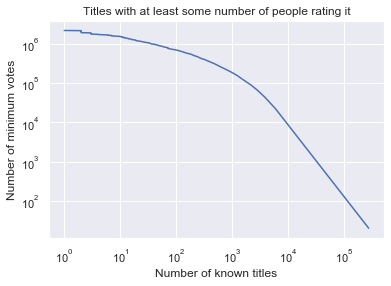

In [13]:
x = np.linspace(20, df.votes.max() ,100)
y = np.array([df[is_known(xi)].tid.count() for xi in x])
plot = plt.loglog(y, x)
plt.ylabel('Number of minimum votes')
plt.xlabel('Number of known titles')
plt.title('Titles with at least some number of people rating it')
plt.show(plot)

This tells us that there are about $10^5$ titles with a minimum of $100$ people rating it. 

So it's fair to say this is a good cutoff if we are interested in giving some meaning to the movies' rating:

In [14]:
df = df[is_known(100)]

We now have 135,135 movies with _at least_ 100 rating them.

Now let's take a look about the behaviour of voters. 
- Maybe people like to log in and rate movies they hated?
- Maybe people only take the time to vote for movies that they actually liked?
- It could also be that people watch movies they already know are likely to enjoy

Let's now look at a more better distribution of the amount of voters:

Let's take a look at movies with at least $2\times10^5$ voters:

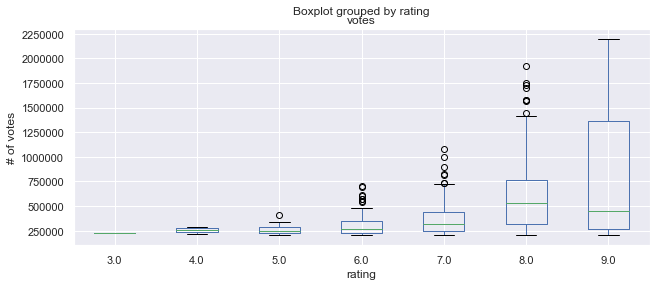

In [15]:
df[is_known(2e5)].boxplot(column='votes', by='rating',figsize=(10,4));
plt.ylabel('# of votes');

It seems like people log in to IMDb and rate a movie only when they liked it. 
Either that or people don't randomlly choose a movie. They only watch the ones they already know they will like.

Since the ratings are ordered and categorical (integers from 1 to 10), a distribution of the votes can be inferred by a simple histogram

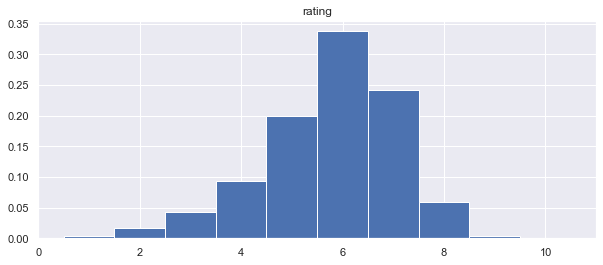

In [16]:
df.hist(column='rating', bins=10, range=(1,11),figsize=(10,4), density=True, align='left');

In [17]:
from scipy.stats import norm

def make_densityplot(lst):
    '''Plot made by assigning a normal distribution on each value of a list.
    If used with a list that has too many points
    this will take a very long time.
    Repeated values will overlap on the tiny marks at the bottom!'''
    
    rango = max(lst)-min(lst)
    x = np.linspace(min(lst)-.1*max(1.5,rango), max(lst)+.1*max(1.5,rango), 1000)
    density = sum(norm(lst[k]).pdf(x) for k in range(len(lst)) ) 
    
    plt.title('Gaussian density distribution')
    plt.plot(lst, np.full_like(lst, -0.1), '|k', markeredgewidth=1)
    return plt.fill_between(x, density, alpha=0.7)

# make_densityplot([1,2,2,3,3,3,3,3,3,3,3,3,3.1,5,6.5,1]);

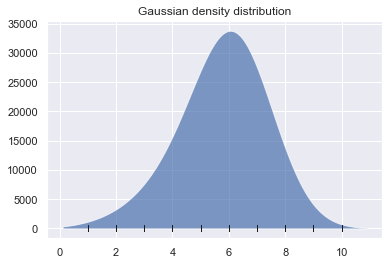

In [36]:
#Better not use it, it is a bit slow for many rows
make_densityplot(df.rating.tolist());

Now we would like to take a look at movies by genre. to do this, we can make use of the nice function `get_dummies` and convert it to a _boolean_ (this last step is just to save some memory space)

In [19]:
dummy = df.genres.str.get_dummies(sep=',').astype('bool')
df = pd.concat([df,dummy], axis=1)

Actually, by doing this we have reduced immensely the memory space of our dataframe!!!

In [20]:
print('Now df uses only ', np.round(df.memory_usage().sum()/(1024**2),5) , 'MB !!')

Now df uses only  14.3053 MB !!


In [21]:
genres_list = df.columns[11:-1].tolist()
genres_list[:-1];#Get rid of \\N

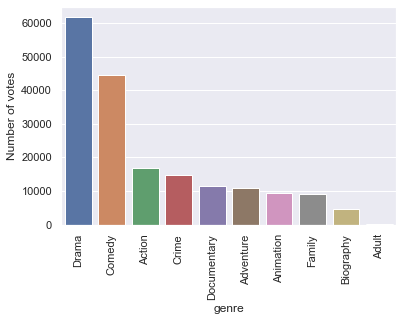

In [22]:
a1 = [[g, df[df[g]].tid.count(), df[df[g]].rating.mean() ] for g in genres_list[:10]]

genres_vote = pd.DataFrame(a1, columns=['genre', 'number','rating']).sort_values('number', ascending=False)
sns.barplot(x='genre',y='number', data = genres_vote)
plt.xticks(rotation=90);
plt.ylabel('Number of votes');

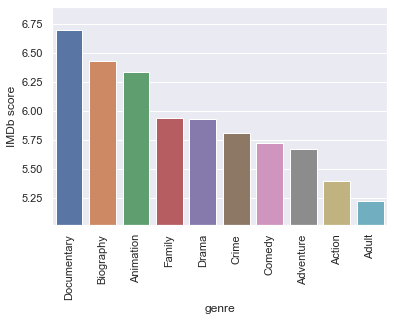

In [23]:
genres_rating = pd.DataFrame(a1, columns=['genre', 'number','rating']).sort_values('rating', ascending=False)
sns.barplot(x='genre',y='rating', data = genres_rating)
plt.xticks(rotation=90);
plt.ylim(min(genres_rating.rating)-.2,max(genres_rating.rating)+.2)
plt.ylabel('IMDb score');

Now let's see how ratings have evolved in general over time

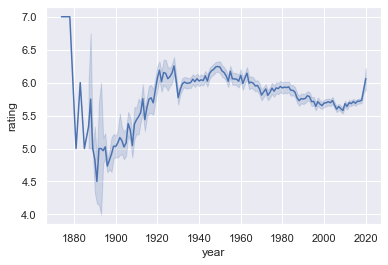

In [24]:
sns.lineplot(x='year', y='rating', data=df);

Now, let's see how the top 5 genres of these days have done in the past 50 years: 

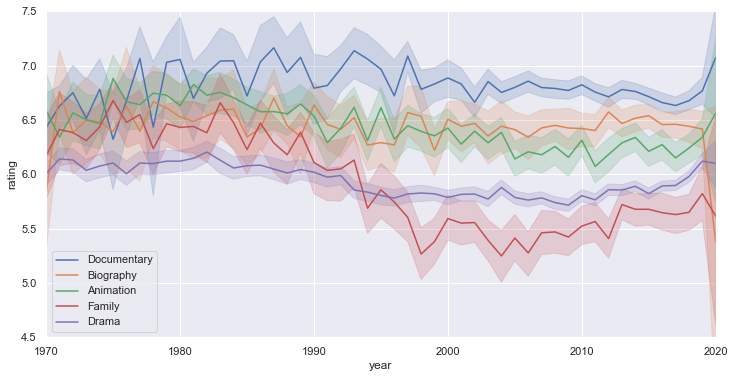

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
for i in genres_rating.genre[:5]:
    sns.lineplot(x='year', y='rating', data=df[df[i]], label=str(i) )
# sns.lineplot(x='year', y='rating', data=df[df['Action']], label=str('Action') )
ax.legend()
plt.ylim(4.5,7.5)
plt.xlim(1970,2020);

Now let's see the top 5 movies of each genre. To trust the rating, we should focus on titles that are already well-known. We'll focus on movies that reach the top score and that are also the most voted. Since some titles have many different categories, some might be repeated:

In [26]:
top5s = pd.DataFrame(columns = df.columns)
for g in genres_rating.genre:
    top5s = top5s.append(df[df[g]].sort_values(by=['rating','votes'], ascending=False)[:5])
# top5s
for k,g in enumerate(genres_rating.genre): 
    print(g,':' ,top5s[top5s[g]].title[:5].tolist(),'\n')

Documentary : ['Planet Earth', 'Cosmos', 'Planet Earth II', 'CM101MMXI Fundamentals', 'Life'] 

Biography : ['When They See Us', 'Bose: Dead/Alive', 'Farouk Omar', 'Ekvtime: Man of God', 'Al-Zeer Salem'] 

Animation : ['Rick and Morty', 'Avatar: The Last Airbender', 'Death Note', 'Fullmetal Alchemist: Brotherhood', 'Batman: The Animated Series'] 

Family : ['Mounam', 'Yeh Meri Family', 'Natsamrat', 'Little Baby', 'The Joy of Painting'] 

Drama : ['When They See Us', 'Farouk Omar', 'Ekvtime: Man of God', 'Al-Zeer Salem', 'Death Note'] 

Crime : ['When They See Us', 'Death Note', 'The Dark Knight', 'The Godfather', 'Breaking Bad'] 

Comedy : ['CM101MMXI Fundamentals', 'Rick and Morty', 'Yeh Meri Family', 'Grief, a Comedy', 'Audition'] 

Adventure : ['Rick and Morty', 'Avatar: The Last Airbender', 'Fullmetal Alchemist: Brotherhood', 'Batman: The Animated Series', 'Rick and Morty'] 

Action : ['Al-Zeer Salem', 'Avatar: The Last Airbender', 'Fullmetal Alchemist: Brotherhood', 'Batman: The A

Now let's look at some values regarding the duration of the films the dataset 

In [27]:
df.duration.describe()

count    127370.000000
mean         88.666091
std          52.693848
min           0.000000
25%          75.000000
50%          91.000000
75%         104.000000
max        5220.000000
Name: duration, dtype: float64

Let's see how the duration of movies has evolved over time:

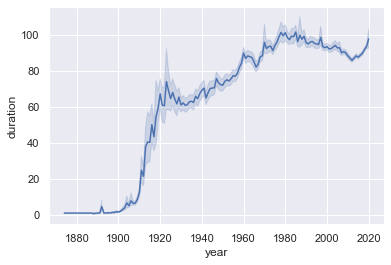

In [28]:
sns.lineplot(x='year', y='duration', data=df);

There are some outliers that lasted for far too long! It would be interesting to point them out and see who were these mad people doing such large films. Let's look at the first 20

In [29]:
df1 = df.sort_values(by=['duration'], ascending=False)
df1[['tid','duration','type', 'directors','title','year', 'rating', 'votes', 'writers']].head()

,tid,duration,type,directors,title,year,rating,votes,writers
250417,tt0284020,5220.0,movie,nm1267224,The Cure for Insomnia,1987.0,5.0,342.0,nm1007137
428176,tt0804414,3900.0,tvSeries,"nm0227486,nm0248119,nm0942185,nm0324426,nm0192463",Desire,2006.0,6.0,253.0,"nm1548597,nm1919867,nm1107925,nm2352020,nm2358..."
388057,tt0459696,3600.0,tvSeries,nm0220720,Kara melek,1997.0,6.0,314.0,"nm0222956,nm1818285"
297327,tt0342707,2880.0,movie,nm3013810,The Longest Most Meaningless Movie in the World,1970.0,5.0,172.0,\N
428543,tt0806000,2150.0,tvSeries,nm1646055,Zona,2006.0,7.0,127.0,"nm6971503,nm2265321"


In [30]:
df1.directors = df1.directors.str.split(',').str[0]

df1 = df1.merge(names[['nid','name']], how='left', left_on='directors', right_on='nid')
df1 = df1.rename(columns={'name':'directors_name'})

In [31]:
df1[['tid','title','directors_name','duration','rating','type']].head(20)

,tid,title,directors_name,duration,rating,type
0,tt0284020,The Cure for Insomnia,NaN,5220.0,5.0,movie
1,tt0804414,Desire,Dennis Dimster,3900.0,6.0,tvSeries
2,tt0459696,Kara melek,NaN,3600.0,6.0,tvSeries
3,tt0342707,The Longest Most Meaningless Movie in the World,NaN,2880.0,5.0,movie
4,tt0806000,Zona,NaN,2150.0,7.0,tvSeries
5,tt0764146,The Other Day 1961-2003: Our Era,Dzhanik Fayziev,1932.0,8.0,tvSeries
6,tt0096725,War and Remembrance,Dan Curtis,1620.0,8.0,tvMiniSeries
7,tt7163910,Heimat II: A Chronicle of a Generation,NaN,1532.0,8.0,tvSeries
8,tt2008009,The Clock,NaN,1440.0,8.0,movie
9,tt0240256,BBC News 24,NaN,1440.0,6.0,tvSeries


These are the directors of our outliers!
Anyway, since these are not necessarily important, let's get rid of 30 of them.

There are also some titles that don't last even for a minute. Let' remove them from this analysis.

In [32]:
df1 = df1[df1.duration>1][30:]

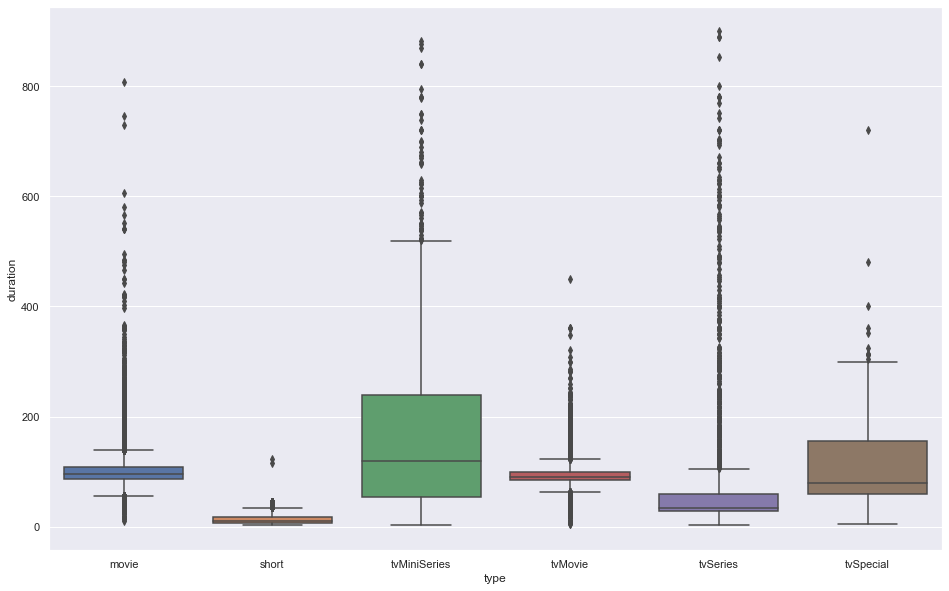

In [33]:
plt.figure(figsize=(16,10))
sns.boxplot(y='duration', x='type',data=df1);

Of these I think movies is an interesting type of title to look at:

In [34]:
df1[df1.type=='movie'][70:]

,tid,type,title,year,rating,directors,writers,duration,votes,isAdult,...,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N,nid,directors_name
641,tt0082728,movie,Mera spored mera,1981.0,7.0,nm0006590,"nm0045572,nm0151572,nm0006590",288.0,191.0,False,...,False,False,False,False,False,False,False,False,nm0006590,Georgi Djulgerov
642,tt0262240,movie,As I Was Moving Ahead Occasionally I Saw Brief...,2000.0,8.0,nm0577263,nm0577263,288.0,822.0,False,...,False,False,False,False,False,False,False,False,nm0577263,Jonas Mekas
643,tt0096403,movie,Time of Violence,1988.0,9.0,nm0821552,"nm0199101,nm0232340,nm1097845,nm0817153",288.0,1958.0,False,...,False,False,False,False,False,False,False,False,nm0821552,Ludmil Staikov
645,tt0072021,movie,The Deluge,1974.0,7.0,nm0388956,"nm0388956,nm0450006,nm0797197,nm0958552",287.0,2152.0,False,...,False,False,False,False,False,False,False,False,nm0388956,Jerzy Hoffman
652,tt0033040,movie,The Shadow,1940.0,7.0,nm0395023,"nm0688853,nm0199291,nm0640784,nm0317212",285.0,229.0,False,...,False,False,False,False,False,False,False,False,nm0395023,James W. Horne
656,tt0032557,movie,The Green Archer,1940.0,6.0,nm0395023,"nm0185170,nm0194019,nm0240546,nm0395023,nm0908624",285.0,128.0,False,...,False,False,False,False,False,False,False,False,nm0395023,James W. Horne
660,tt0090559,movie,16 Days of Glory,1986.0,7.0,nm0339175,\N,284.0,145.0,False,...,False,False,True,False,False,False,False,False,nm0339175,Bud Greenspan
671,tt0028241,movie,Shadow of Chinatown,1936.0,4.0,nm0384616,"nm0384616,nm0225458,nm0118090",281.0,199.0,False,...,False,False,False,False,False,False,False,False,nm0384616,Robert F. Hill
673,tt0025509,movie,Les Misérables,1934.0,8.0,nm0076368,"nm0401076,nm0076368,nm0485676",281.0,1453.0,False,...,False,False,False,False,False,False,False,False,nm0076368,Raymond Bernard
678,tt10244756,movie,The Halt,2019.0,6.0,nm0225010,\N,279.0,101.0,False,...,True,False,False,False,False,False,False,False,nm0225010,Lav Diaz


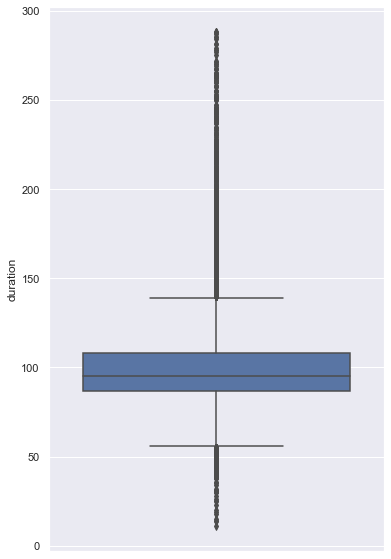

In [35]:
plt.figure(figsize=(6,10))
sns.boxplot(y='duration',data=df1[df1.type=='movie'][70:]);
## We have removed an extra 70, making this a boxplot without the first 100 outliers